<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/bayesian_machine_learning/stochastic_volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Volatility model

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pymc3 as pm
import arviz
from pymc3.distributions.timeseries import GaussianRandomWalk

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=be013f1147a7170ece02f88e96857636fb101cc310eec83877c302ce0e04b386
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
import yfinance as yf

In [5]:
sns.set_style('whitegrid')
# model_path = Path('models')

## Model assumptions

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$\begin{align*} 
\sigma &\sim \text{Exponential}(50)\\
\nu &\sim \text{Exponential}(.1)\\
s_i &\sim \text{Normal}(s_{i-1}, \sigma^{-2})\\
\log(r_i) &\sim t(\nu, 0, \exp(-2 s_i))
\end{align*}$$

Here, $r$ is the daily return series and $s$ is the latent log volatility process.

## Get Return Data

First we load some daily returns of the S&P 500.

In [6]:
nifty = yf.download('^nsei',start='2012-01-01')
log_returns = np.log(nifty["Close"]).diff().dropna()

[*********************100%***********************]  1 of 1 completed


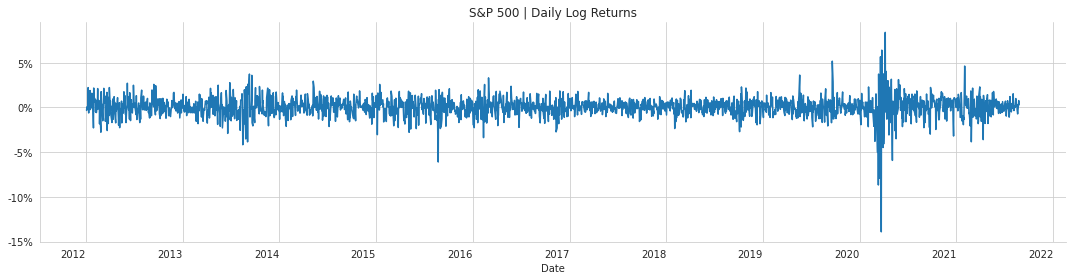

In [7]:
ax = log_returns.plot(figsize=(15, 4),
                      title='S&P 500 | Daily Log Returns',
                      rot=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout();

As you can see, the volatility seems to change over time quite a bit while clustering around certain time-periods, most notably the 2009 financial crash.

## Specify Model in PyMC3

Specifying the model in `PyMC3` mirrors its statistical specification. 

In [8]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size, 
                           shape=len(log_returns))
    nu = pm.Exponential('nu', .1)
    r = pm.StudentT('r', nu=nu, 
                    lam=pm.math.exp(-2*s), 
                    observed=log_returns)

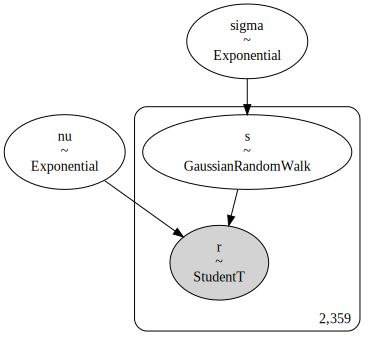

In [9]:
pm.model_to_graphviz(model)

## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. NUTS, however, gives the correct posterior.

In [10]:
with model:
    trace = pm.sample(tune=2000, 
                      draws=5000,
                      chains=4,
                      cores=1,
                      target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [nu, s, sigma]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7357 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Optionally, persist result as pickle:

In [16]:
import pickle
with open('model_vol.pkl', 'wb') as buff:
  pickle.dump({'model': model, 'trace': trace}, buff)

## Evaluate results

### Trace Plot

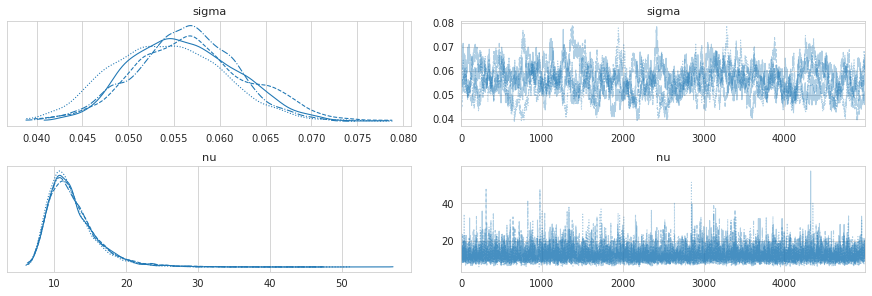

In [12]:
arviz.plot_trace(trace, var_names=['sigma', 'nu']);

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

### In-Sample Predictions

In [13]:
pm.trace_to_dataframe(trace).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 2361 entries, s__0 to nu
dtypes: float64(2361)
memory usage: 360.3 MB


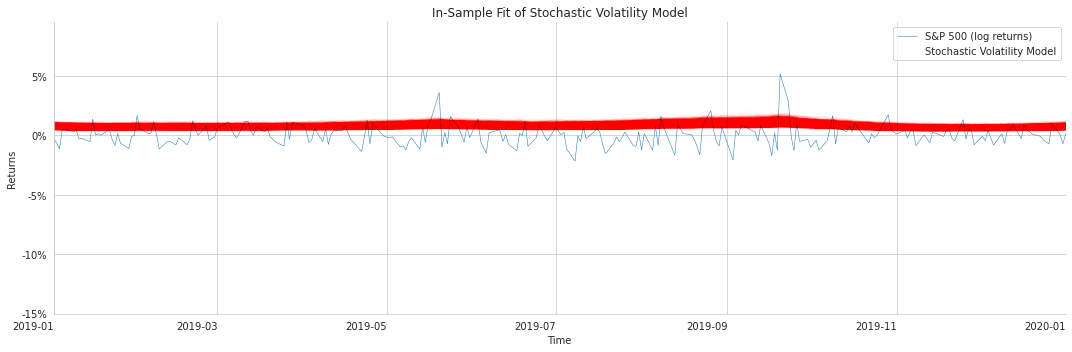

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))

log_returns.plot(ax=ax, lw=.5, xlim=('2019', '2020'), rot=0,
                 title='In-Sample Fit of Stochastic Volatility Model')

ax.plot(log_returns.index, np.exp(trace[s]).T, 'r', alpha=.03, lw=.5)

ax.set(xlabel='Time', ylabel='Returns')
ax.legend(['S&P 500 (log returns)', 'Stochastic Volatility Model'])
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.despine()
fig.tight_layout()